## Markov Chain Monte Carlo and Sampling
LSSTC Data Science Fellowship Program Session 16

**Jiayin Dong**, Flatiron Research Fellow

CCA, Flatiron Institute

September 2022

---

In the lecture, we introduced a new approach to approximate the posterior -- Markov Chain Monte Carlo (MCMC). The MCMC technique is powerful when we study high-dimensional problems. We discussed two algorithms of MCMC: the Metropolis-Hastings algorithm and the Hamiltonian Monte Carlo algorithm. You may find the lecture material in this folder (https://github.com/jiayindong/LSSTC-DSFP-Sessions/tree/main/Sessions/Session16/Day2).

The problem set here is to build and apply the Metropolis sampling to two problems we have worked on: (1) Draw balls out of a bag and (2) Fit a straight line to data.

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
from matplotlib import rc
#rc('font', **{'family':'sans-serif'})
#rc('text', usetex=True)

### Problem 1: Draw balls out of a bag

We have a bag containing 4 balls. Each ball has two possible colors: black and white. We begin with no information on the number of black and white balls in the bag and want to update our guess on the number of black balls from observations (i.e., drawing balls out of the bag).

We drew one ball out of the bag. And it is black.

Let's use the MCMC to approximate the posterior.

**Metroplis sampling**

Begin with a random state $\theta_i$.

While runs > 0:

- Calculate $P(\theta_{\rm cur}|D) = p(D|\theta_{\rm cur})p(\theta_{\rm cur})$.

- Flip a coin.
    - If head, propose to move to cur+1
    - If tail, propose to visit cur-1
    
- Calculate $P(\theta_{\rm prop}|D) = p(D|\theta_{\rm prop})p(\theta_{\rm prop})$.

- Caculate $\alpha = P(\theta_{\rm prop}|D)/P(\theta_{\rm cur}|D)$.
    - If $\alpha > 1$, accept the proposal.
    - Else, accept the proposal with probability of $\alpha$.
    
- Record cur.

- runs -= 1

Let's first write two helper functions.

The prior function computes and returns the prior at a certain state. Again, we assume an uninformative prior.

The likelihood function computes and returns the likelihood at a certain state.

In [3]:
def prior(state):
    return 1/5
    
def likelihood(state):
    return state/4

Now, time for the MCMC.

In [4]:
records = []

cur = 2  # Let's pick a random state cur = 2.

runs = 1000  # With 1000 runs
while runs > 0:
    
    # Calculate P(cur)
    p_cur = prior(cur)*likelihood(cur)

    # Make a proposal
    prop = cur+np.random.choice([-1,1])
    prop = prop%5
        
    # Calculate P(prop)
    p_prop = prior(prop)*likelihood(prop)
        
    # Accept or not?
    α = p_prop/p_cur
    if α > 1:
        cur = prop
    else:
        if α > np.random.rand():
            cur = prop
    
    # Record the cur
    records.append(cur)

    runs -= 1

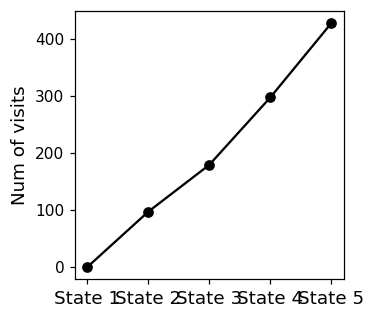

In [9]:
## Plot the posterior distribution
plt.figure(figsize=(3.5,3),dpi=110)
plt.plot(np.bincount(records),'-o',c='k')
plt.xticks(np.arange(5), ['State 1','State 2','State 3','State 4','State 5'],fontsize=12)
plt.ylabel('Num of visits',fontsize=12)
plt.tight_layout()
plt.show()

Try increase the number of runs. Redo the analysis.

### Problem 2: Fit a straight line to data

We have two parameters of interest, the slope of the line $m$ and the intercept of the line $b$. The line model is described as $y = mx + b$.

We made 10 observations of y but with some Gaussian noise $\sigma$. Assume that we know the exact x values.

Let's generate some data.

In [30]:
np.random.seed(42)

x = np.linspace(-1,1,10)

m_true = 1.
b_true = 0.5
y_true = m_true*x + b_true

σ = 0.2

y_obs = y_true + np.random.normal(size=len(y_true))*σ

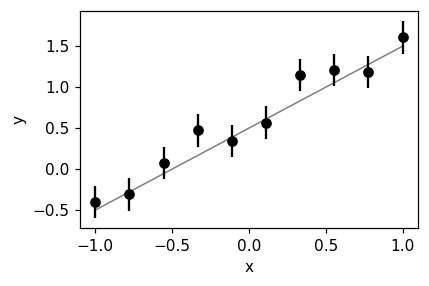

In [31]:
plt.figure(figsize=(4,2.7),dpi=110)
plt.errorbar(x, y_obs, yerr=σ, linestyle='', fmt='o', c='k')
plt.plot(x, y_true, c='grey', lw=1, zorder=0)
plt.ylabel('y')
plt.xlabel('x')
plt.tight_layout()
plt.show()

In [32]:
## Use our results from the grid approximation for plotting purpose
mgrid = np.linspace(0,2,200)
bgrid = np.linspace(0,1,100)
mv, bv = np.meshgrid(mgrid, bgrid)

## The priors
prior_m = np.ones_like(mgrid)/200
prior_b = np.ones_like(bgrid)/100

prior_mv, prior_bv = np.meshgrid(prior_m, prior_b)

log_prior = np.log(prior_mv)+np.log(prior_bv)

## The likelihood
log_likelihood = 0.
for i, this_y_obs in enumerate(y_obs):
    
    this_y_true = mv*x[i] + bv
    
    log_likelihood += stats.norm.logpdf(this_y_obs, this_y_true, σ)

## The posterior
log_posterior = log_prior + log_likelihood
posterior = np.exp(log_posterior)
posterior /= np.sum(posterior)

We could again use the MCMC to approximate the posterior.

**Metroplis sampling**

Begin with a random state $\theta_i = \{m_i, b_i\}$.

While runs > 0:

- Calculate $P(\theta_{\rm cur}|D) = p(D|\theta_{\rm cur})p(\theta_{\rm cur})$.

- Make a proposal. Assume Gaussian random walk with a step size of 0.1.
    - $ \theta_{\rm prop} = \theta_{\rm cur} + \mathcal{N}$(0, 0.1, size=2)
    
- Calculate $P(\theta_{\rm prop}|D) = p(D|\theta_{\rm prop})p(\theta_{\rm prop})$.

- Caculate $\alpha = P(\theta_{\rm prop}|D)/P(\theta_{\rm cur}|D)$.
    - If $\alpha > 1$, accept the proposal.
    - Else, accept the proposal with probability of $\alpha$.
    
- Record $\theta_{\rm cur}$.

- runs -= 1

Again, let's write two helper functions to compute the log_prior and log_likelihood for a certain state $\theta$.

We assume a uniform prior on m  and b.

$m \sim {\rm Uniform}(0,2)$

$b \sim {\rm Uniform}(0,1)$

In [33]:
def log_prior(θ):
    
    m, b = θ
    
    ## log_prior on m
    if (m > 0) and (m < 2):
        log_prior_m = np.log(1/2)
    else:
        log_prior_m = -np.inf
    
    ## log_prior on b
    if (b > 0) and (b < 1):
        log_prior_b = np.log(1.)
    else:
        log_prior_b = -np.inf
    
    return log_prior_m + log_prior_b

def log_likelihood(θ, y_obs, x, σ):
    
    m, b = θ
    y_true = m*x + b
        
    return np.sum(stats.norm.logpdf(y_obs,y_true,σ))

#### Problem 2(a) Run the MCMC.

In [53]:
θ_cur = np.array([0.5,0.5]) # m_cur = 0, b_cur = 0
trace_θ = []

runs = 50000
while runs > 0:
    
    ## log(P) at θ_cur
    logP_θ_cur = log_prior(θ_cur)+log_likelihood(θ_cur, y_obs, x, σ)
    
    ## Make a proposal, assuming gaussain random walk
    θ_prop = θ_cur + np.random.normal(loc=0, scale=0.01, size=2)
    
    ## log(P) at θ_prop
    logP_θ_prop = log_prior(θ_prop)+log_likelihood(θ_prop, y_obs, x, σ)
    
    ## Decide if accept the proposal or not
    if (logP_θ_prop - logP_θ_cur) > np.log(np.random.rand()):
        θ_cur = θ_prop
    
    trace_θ.append(θ_cur)
    
    runs -= 1

trace_θ = np.array(trace_θ)

<ipython-input-59-c072ea7281fe>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(mgrid,bgrid,posterior,cmap='plasma')


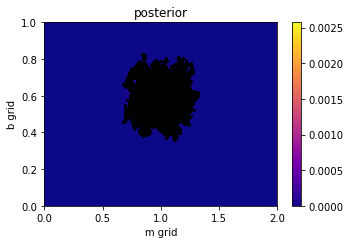

In [59]:
plt.figure(figsize=(5,3.5))
plt.pcolormesh(mgrid,bgrid,posterior,cmap='plasma')
plt.plot(trace_θ[1000:,0],trace_θ[1000:,1],'-o',c='k',markersize=2.)
plt.xlabel('m grid')
plt.ylabel('b grid')
plt.colorbar()
plt.title('posterior')
plt.tight_layout()
plt.show()

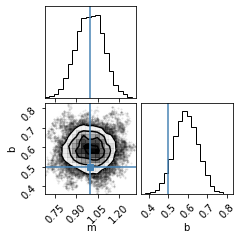

In [55]:
import corner
data = np.array([trace_θ[1000:,0],trace_θ[1000:,1]]).T

fig = corner.corner(data, labels=["m", "b"], truths=[m_true, b_true])
fig.set_size_inches(3.5, 3.5)

#### Problem 2(b) Increase the number of runs. 

Increase the number of runs from 100 to 1000 and 10,000. Redo the analysis.

How does the number of runs affect the posterior approximation?

#### Problem 2(c) Change the step size.

Change the step size of the Gaussian walker from 0.1 to 0.01 and 1. Redo the analysis.

How do different step sizes affect the posterior approximation?